In [68]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Geostatistical functions
from scipy.stats import norm, lognorm
import gstools as gs
from gstools import SRF, Exponential, Matern, Gaussian, krige

# Set seaborn style
sns.set_theme()
# Set colorblind-friendly palette
sns.set_palette("colorblind")

# Start with intervariability

In [3]:
# 1D Grid
x = np.linspace(0, 2000, 2001)

# Statistics of depth - Uniform distribution
mean_z = (145-5)/2
std_z = np.sqrt((145-5)**2/12)
print(f"Mean: {mean_z}, Std: {std_z}")

Mean: 70.0, Std: 40.414518843273804


In [4]:
# Autocorrelation factors
rH = 50
aVH = 1/10
0.25*rH

12.5

In [5]:
# Conditional random field

## Conditional positions
x_cond = np.random.choice(x, 1)
y_cond = np.random.randint(5,145,1)
print(f"Conditioned position: {x_cond}, {y_cond}")
print(x_cond.shape, y_cond.shape)

Conditioned position: [468.], [78]
(1,) (1,)


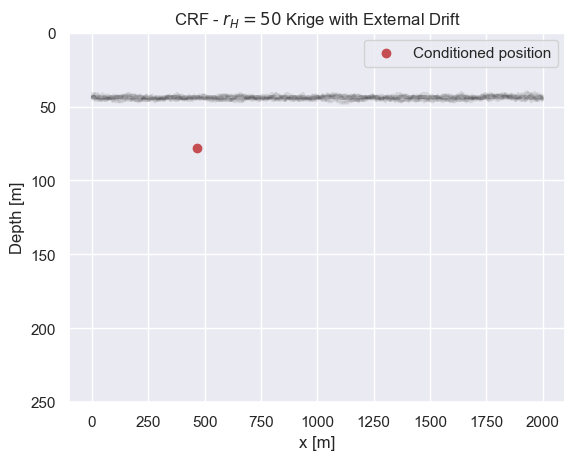

In [212]:
## Model - Depth
model = Exponential(dim=1, var=1, len_scale=rH)
model_T = Exponential(dim=1, var=1, len_scale=rH)

## Lognormal
normalizer = gs.normalizer.LogNormal

## Transition zone
# Transition zone - 1D
mean_T = 0
std_T = 0.5

## Conditional transition zone
t_model = SRF(model_T, mean=mean_T, std=std_T)
t_cond = t_model(x_cond)

## Kringing
kridge = krige.ExtDrift(model, cond_pos=x_cond, cond_val=y_cond, ext_drift=t_cond)
cond_srf = gs.CondSRF(krige=kridge, normalizer=normalizer)
cond_srf.set_pos(x)

## Simulation
realizations = []
for i in range(10):
    ext_drift_values = t_model(x, seed=np.random.randint(0, 10000))
    realization = cond_srf(seed=np.random.randint(0, 10000), ext_drift=np.zeros(x.shape))
    realizations.append(realization)

# Plot the realizations
ax = plt.subplot()
for i, realization in enumerate(realizations):
    ax.plot(x, np.round(realization), color="k", alpha=0.1)

ax.scatter(x_cond, y_cond, color="r", label="Conditioned position")
plt.ylim([0, 250])
plt.gca().invert_yaxis()
plt.legend()
plt.title(rf"CRF - $r_H = {rH}$ Krige with External Drift")
plt.xlabel("x [m]")
plt.ylabel("Depth [m]")

plt.show()

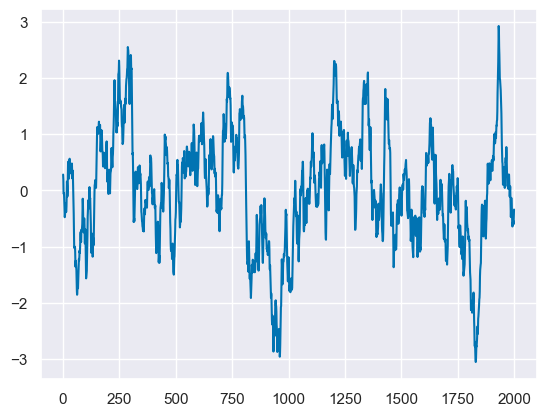

In [208]:
plt.plot(x, ext_drift_values)

In [206]:
np.all(realization >=0)

False

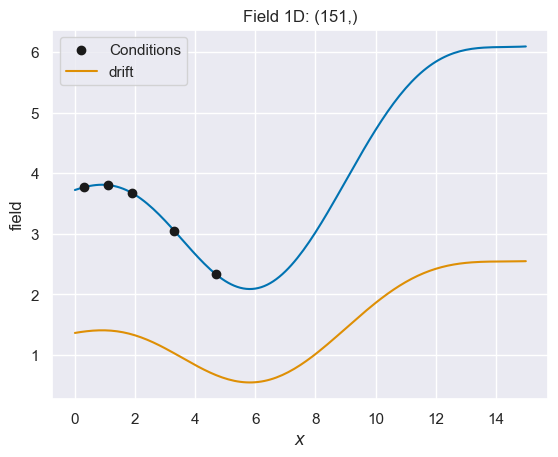

In [70]:
# synthetic condtions with a drift
drift_model = Gaussian(dim=1, len_scale=4)
drift = SRF(drift_model, seed=1010)
cond_pos = [0.3, 1.9, 1.1, 3.3, 4.7]
ext_drift = drift(cond_pos)
cond_val = ext_drift * 2 + 1
# resulting grid
gridx = np.linspace(0.0, 15.0, 151)
grid_drift = drift(gridx)
# kriging
model = Gaussian(dim=1, var=1, len_scale=4)
krig = krige.ExtDrift(model, cond_pos, cond_val, ext_drift)
krig(gridx, ext_drift=grid_drift)
ax = krig.plot()
ax.scatter(cond_pos, cond_val, color="k", zorder=10, label="Conditions")
ax.plot(gridx, grid_drift, label="drift")
ax.legend()

# Use of Transitions Zones

Additional to the random filed of depth, we can include a transition zone due to the inherent errors and noise that boreholes have. Also, to bound the depth. 